In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/FU_连1_连2.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['FU 连1-连2'].last_valid_index()
 
future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=21, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,FU 连1-连2,新加坡高硫燃料油380裂解价差,山东汽柴油加权裂解价差,原油：山东独立炼厂：开工率：新口径（周）超季节性/3年,SC-Brent（盘面）,SC原油连1-连3月差,新加坡92#汽油裂解价差,Brent-Dubai/7DMA,新加坡10ppm柴油裂解,山东柴油裂解差/5DMA,新加坡0.5%低硫燃料油裂解价差,WTI连1-连4月差,(Dubai连1-连4月差)-(Brent连1-连4月差),FU 连1-连2Seasonal/F0.2(预测/过去3年季节性),SC期货指数-Brent原油期货价格
2025-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.2789,NaN
2025-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.6277,NaN
2025-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.6314,NaN
2025-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.0021,NaN
2025-12-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.9535,NaN


In [5]:
# 尝试多个可能的文件路径
file_paths = [
    os.path.expanduser("~/Desktop/X-BASE/燃料油/eta/新加坡高硫燃料油380裂解价差_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/燃料油/eta/新加坡高硫燃料油380裂解价差_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/燃料油/eta/新加坡高硫燃料油380裂解价差_合并数据.xlsx")
]

file_path = None
for path in file_paths:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path = path
        break

if file_path is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet1 = pd.read_excel(file_path, sheet_name='Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    sheet1 = sheet1.drop(columns=['真实值'])
    sheet1 = sheet1.dropna()
    sheet1 = sheet1.sort_values('Date', ascending=True)
    sheet1.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet1.head()

,Date,预测值
23,2025-11-09,-4.7
22,2025-11-10,-4.7
21,2025-11-11,-4.9
20,2025-11-12,-4.3
19,2025-11-13,-4.3


In [6]:
# 尝试多个可能的文件路径
file_paths1 = [
    os.path.expanduser("~/Desktop/X-BASE/燃料油/eta/新加坡0.5%低硫燃料油裂解价差_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/燃料油/eta/新加坡0.5%低硫燃料油裂解价差_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/燃料油/eta/新加坡0.5%低硫燃料油裂解价差_合并数据.xlsx")
]

file_path1 = None
for path1 in file_paths1:
    if os.path.isfile(path1):  # 确保是文件而不是目录
        file_path1 = path1
        break

if file_path1 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet11 = pd.read_excel(file_path1, sheet_name='Sheet1')
    sheet11['Date'] = pd.to_datetime(sheet11['Date'], errors='coerce')
    sheet11 = sheet11.drop(columns=['真实值'])
    sheet11 = sheet11.dropna()
    sheet11 = sheet11.sort_values('Date', ascending=True)
    sheet11.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet11.head()

,Date,预测值
20,2025-11-10,7.54
19,2025-11-11,7.67
18,2025-11-12,7.08
17,2025-11-13,7.65
16,2025-11-14,7.43


In [7]:
sheet3 = pd.ExcelFile('eta/山东柴油裂解差(多因子)_合并数据.xlsx').parse('Sheet1')
sheet3['Date'] = pd.to_datetime(sheet3['Date'], errors='coerce')
sheet3 = sheet3.sort_values('Date', ascending=True)
sheet3 = sheet3.drop(columns=['真实值'])
sheet3 = sheet3.dropna()
sheet3.head()

,Date,预测值
19,2025-11-10,622.9
18,2025-11-11,585.9
17,2025-11-12,604.8
16,2025-11-13,549.8
15,2025-11-14,574.2


In [8]:
sheet4 = pd.ExcelFile('eta/汽油裂解差(多因子)_合并数据.xlsx').parse('Sheet1')
sheet4['Date'] = pd.to_datetime(sheet4['Date'], errors='coerce')
sheet4 = sheet4.sort_values('Date', ascending=True)
sheet4 = sheet4.drop(columns=['真实值'])
sheet4 = sheet4.dropna()
sheet4.head()

,Date,预测值
19,2025-11-10,427.2
18,2025-11-11,412.2
17,2025-11-12,427.9
16,2025-11-13,388.5
15,2025-11-14,405.2


In [9]:
sheet2 = sheet1.copy()
sheet2['山东汽柴油加权裂解价'] = (sheet4['预测值'] + 2*sheet3['预测值']) / 3
sheet2.head()

,Date,预测值,山东汽柴油加权裂解价
23,2025-11-09,-4.7,NaN
22,2025-11-10,-4.7,NaN
21,2025-11-11,-4.9,NaN
20,2025-11-12,-4.3,NaN
19,2025-11-13,-4.3,557.666667


In [10]:
sheet5 = pd.ExcelFile('eta/SC期货指数-Brent原油期货价格_合并数据.xlsx').parse('Sheet1')
sheet5['Date'] = pd.to_datetime(sheet5['Date'], errors='coerce')
sheet5 = sheet5.sort_values('Date', ascending=True)
sheet5 = sheet5.drop(columns=['真实值'])
sheet5 = sheet5.dropna()
sheet5.head()

,Date,预测值
20,2025-11-10,7.6
19,2025-11-11,6.0
18,2025-11-12,5.1
17,2025-11-13,5.6
16,2025-11-14,5.9


In [11]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['新加坡高硫燃料油380裂解价差'] = sheet_daily['新加坡高硫燃料油380裂解价差'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

sheet_daily = pd.merge(
    sheet_daily,
    sheet11[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['新加坡0.5%低硫燃料油裂解价差'] = sheet_daily['新加坡0.5%低硫燃料油裂解价差'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', '山东汽柴油加权裂解价']],
    on='Date',
    how='left'
)
sheet_daily['山东汽柴油加权裂解价差'] = sheet_daily['山东汽柴油加权裂解价差'].fillna(sheet_daily['山东汽柴油加权裂解价'])
sheet_daily = sheet_daily.drop(columns=['山东汽柴油加权裂解价'])


sheet_daily = pd.merge(
    sheet_daily,
    sheet3[['Date', '预测值']].assign(预测值=lambda x: x['预测值'].rolling(5).mean()),
    on='Date',
    how='left'
)
sheet_daily['山东柴油裂解差/5DMA'] = sheet_daily['山东柴油裂解差/5DMA'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

sheet_daily = pd.merge(
    sheet_daily,
    sheet5[['Date', '预测值']].assign(预测值=lambda x: x['预测值'].rolling(5).mean()),
    on='Date',
    how='left'
)
sheet_daily['SC期货指数-Brent原油期货价格'] = sheet_daily['SC期货指数-Brent原油期货价格'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [12]:
sheet.columns

Index(['FU 连1-连2', '新加坡高硫燃料油380裂解价差', '山东汽柴油加权裂解价差',
       '原油：山东独立炼厂：开工率：新口径（周）超季节性/3年', 'SC-Brent（盘面）', 'SC原油连1-连3月差',
       '新加坡92#汽油裂解价差', 'Brent-Dubai/7DMA', '新加坡10ppm柴油裂解', '山东柴油裂解差/5DMA',
       '新加坡0.5%低硫燃料油裂解价差', 'WTI连1-连4月差', '(Dubai连1-连4月差)-(Brent连1-连4月差)',
       'FU 连1-连2Seasonal/F0.2(预测/过去3年季节性)', 'SC期货指数-Brent原油期货价格'],
      dtype='object')

In [13]:
################################# 处理缺失值 #################################
fill_methods = {
'新加坡高硫燃料油380裂解价差': 'interpolate', 
'山东汽柴油加权裂解价差': 'interpolate',
'原油：山东独立炼厂：开工率：新口径（周）超季节性/3年': 'interpolate', 
'SC-Brent（盘面）': 'interpolate', 
'SC原油连1-连3月差': 'interpolate',
'新加坡92#汽油裂解价差': 'interpolate', 
'Brent-Dubai/7DMA': 'interpolate', 
'新加坡10ppm柴油裂解': 'interpolate', 
'山东柴油裂解差/5DMA': 'interpolate',
'新加坡0.5%低硫燃料油裂解价差': 'interpolate', 
'WTI连1-连4月差': 'interpolate',
'(Dubai连1-连4月差)-(Brent连1-连4月差)': 'interpolate',
'SC期货指数-Brent原油期货价格': 'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, '汽油出口利润（华东-新加坡）'] = sheet.loc[:last_day, '汽油出口利润（华东-新加坡）'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['原油：山东独立炼厂：开工率：新口径（周）超季节性/3年_提前35天'] = sheet['原油：山东独立炼厂：开工率：新口径（周）超季节性/3年'].shift(35)
sheet['SC-Brent（盘面）_提前20天'] = sheet['SC-Brent（盘面）'].shift(20)
sheet['SC原油连1-连3月差_提前20天'] = sheet['SC原油连1-连3月差'].shift(20)
sheet['新加坡92#汽油裂解价差_提前60天'] = sheet['新加坡92#汽油裂解价差'].shift(60)
sheet['Brent-Dubai/7DMA_提前20天'] = sheet['Brent-Dubai/7DMA'].shift(20)
sheet['新加坡10ppm柴油裂解_提前60天'] = sheet['新加坡10ppm柴油裂解'].shift(60)
sheet['WTI连1-连4月差_提前20天'] = sheet['WTI连1-连4月差'].shift(20)
sheet['(Dubai连1-连4月差)-(Brent连1-连4月差)_提前20天'] = sheet['(Dubai连1-连4月差)-(Brent连1-连4月差)'].shift(20)
sheet['SC期货指数-Brent原油期货价格_提前10天'] = sheet['SC期货指数-Brent原油期货价格'].shift(10)


################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2022-09-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['FU 连1-连2'].notna())
]

################################# 数据 读取-处理 结束 #################################

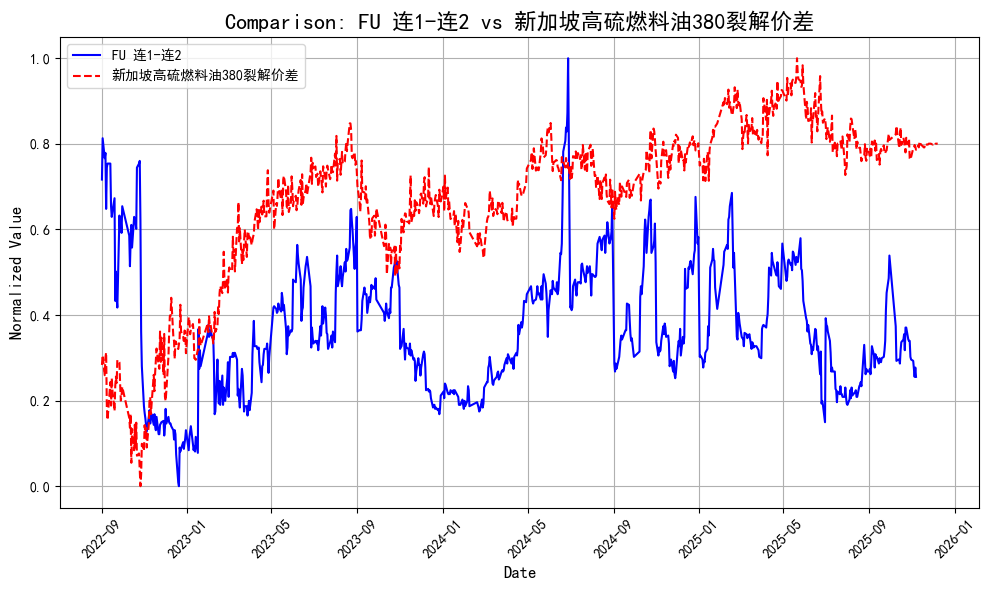

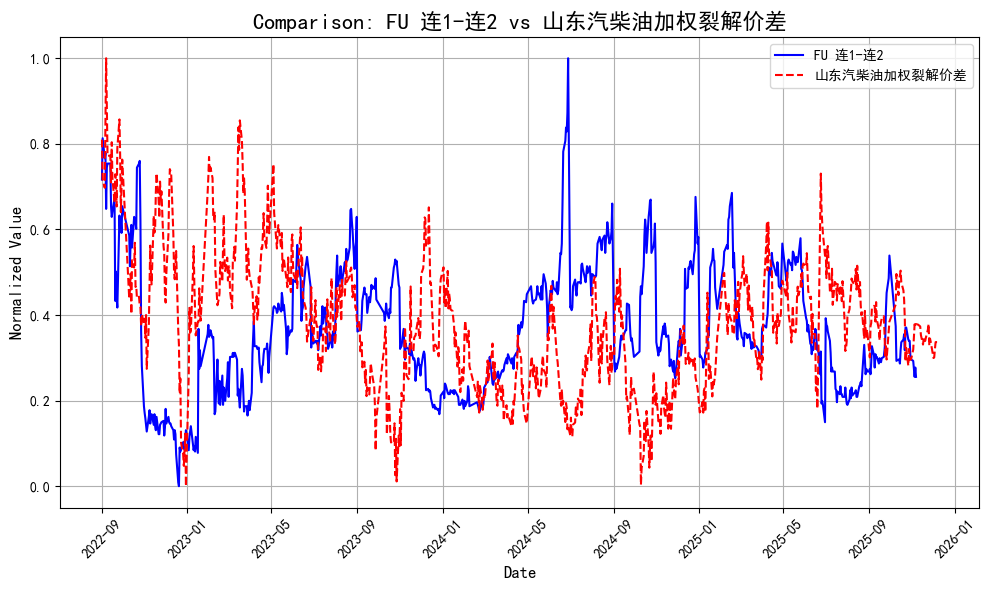

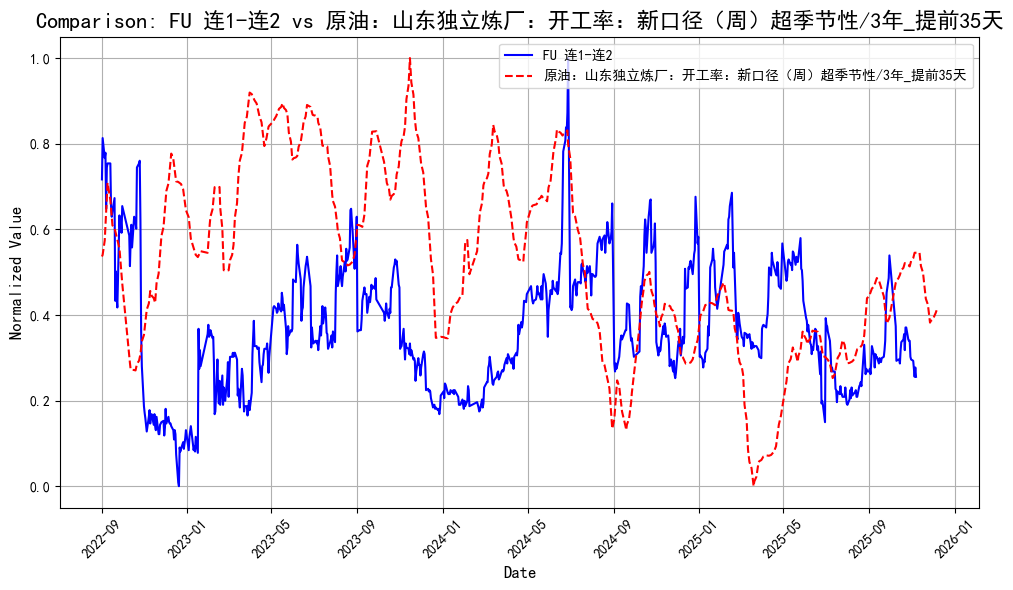

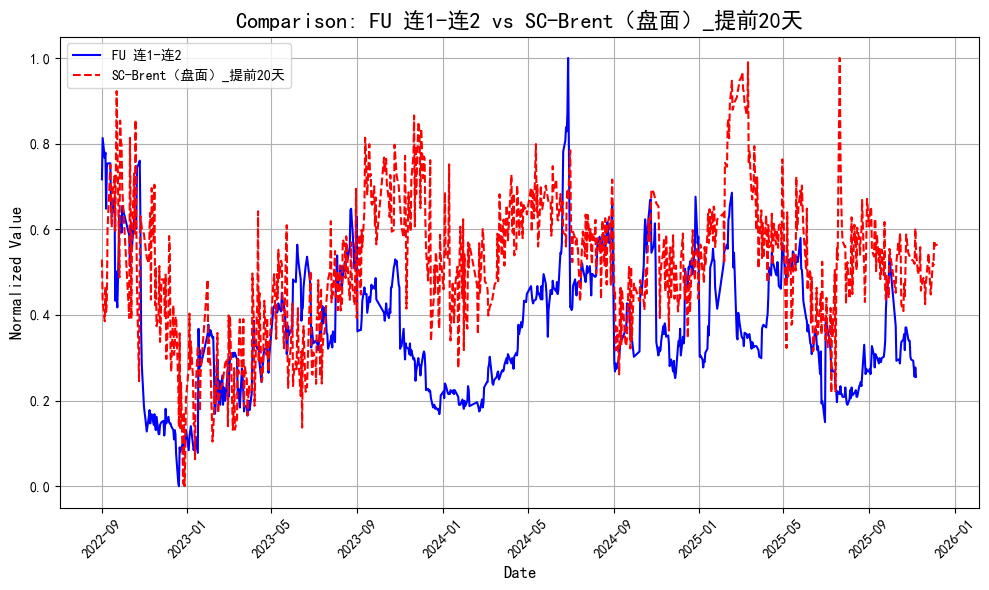

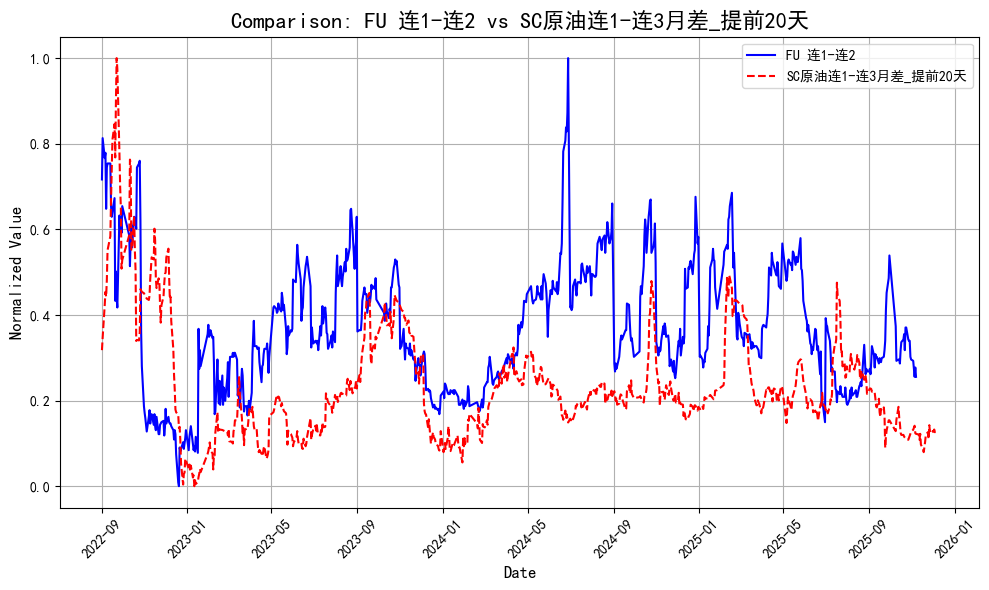

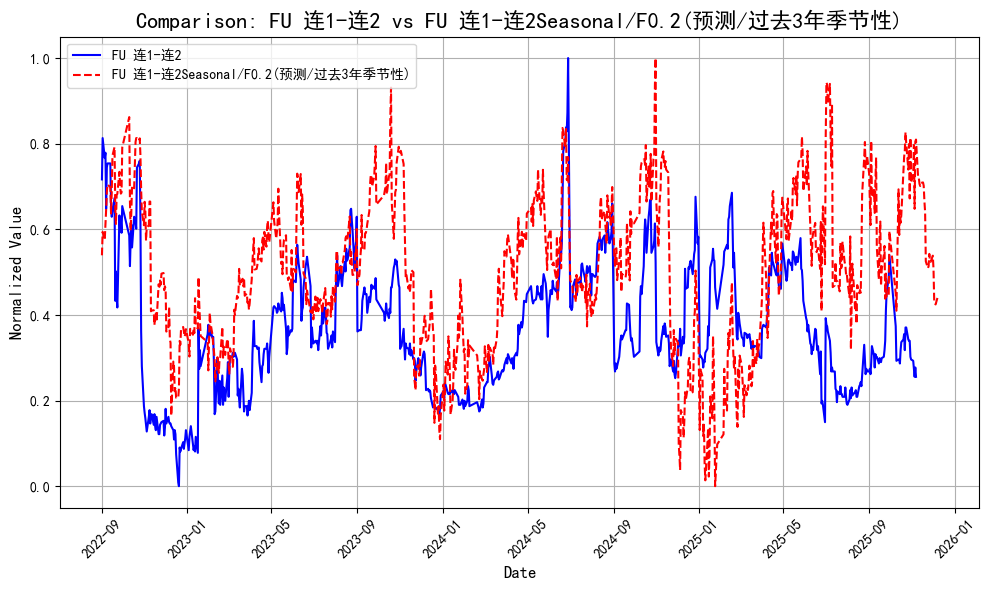

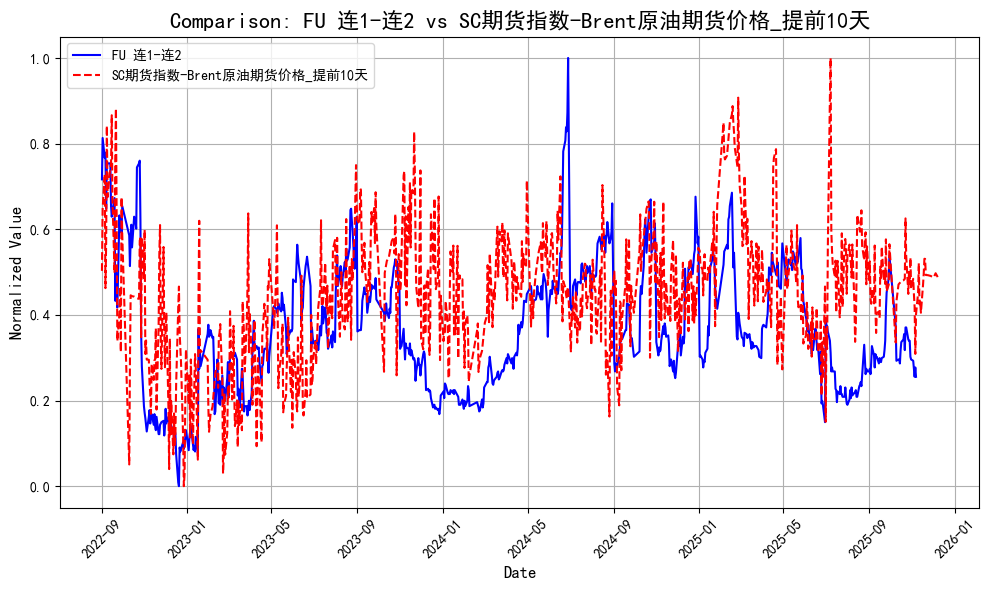

In [14]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='FU 连1-连2', 
    compare_cols=[
        '新加坡高硫燃料油380裂解价差', 
        '山东汽柴油加权裂解价差',
        '原油：山东独立炼厂：开工率：新口径（周）超季节性/3年_提前35天', 
        'SC-Brent（盘面）_提前20天', 
        'SC原油连1-连3月差_提前20天',
        'FU 连1-连2Seasonal/F0.2(预测/过去3年季节性)',
        'SC期货指数-Brent原油期货价格_提前10天'
        ]
)

In [15]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 60
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '新加坡高硫燃料油380裂解价差', 
        '山东汽柴油加权裂解价差',
        '原油：山东独立炼厂：开工率：新口径（周）超季节性/3年_提前35天', 
        #'SC-Brent（盘面）_提前20天', 
        'SC原油连1-连3月差_提前20天',
        '新加坡92#汽油裂解价差_提前60天', 
        'Brent-Dubai/7DMA_提前20天', 
        '新加坡10ppm柴油裂解_提前60天', 
        '山东柴油裂解差/5DMA',
        '新加坡0.5%低硫燃料油裂解价差', 
        'WTI连1-连4月差_提前20天',
        '(Dubai连1-连4月差)-(Brent连1-连4月差)_提前20天',
        'FU 连1-连2Seasonal/F0.2(预测/过去3年季节性)',
        'SC期货指数-Brent原油期货价格_提前10天'
]

predict_column = 'FU 连1-连2'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.1,  # 默认学习率
    'max_depth': 12,  # 默认树深度
    'min_child_weight': 0.84,  # 默认最小子节点权重
    'subsample': 0.6,  # 默认子采样比例
    'colsample_bytree': 0.4,  # 默认特征采样比例
    'gamma': 0.21,  # 默认最小分裂损失
    'reg_alpha': 0.5,  # 默认L1正则化
    'reg_lambda': 0.3,  # 默认L2正则化
    'eval_metric': 'rmse',  # 评估指标
    'seed': 42,  # 随机种子
#    'tree_method': 'auto'  # 默认树方法
}


num_boost_round = 3000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:30.62895	train-rmse:43.35736


[500]	eval-rmse:51.79190	train-rmse:0.26972


[1000]	eval-rmse:51.80823	train-rmse:0.25402


[1500]	eval-rmse:51.81135	train-rmse:0.24723


[2000]	eval-rmse:51.81382	train-rmse:0.24266


[2500]	eval-rmse:51.82176	train-rmse:0.23920


[2999]	eval-rmse:51.80359	train-rmse:0.23713


训练集 MSE (DMatrix): 0.0664, 训练集 R² (DMatrix): 1.0
测试集 MSE (DMatrix): 2683.6122, 测试集 R² (DMatrix): -5.7363


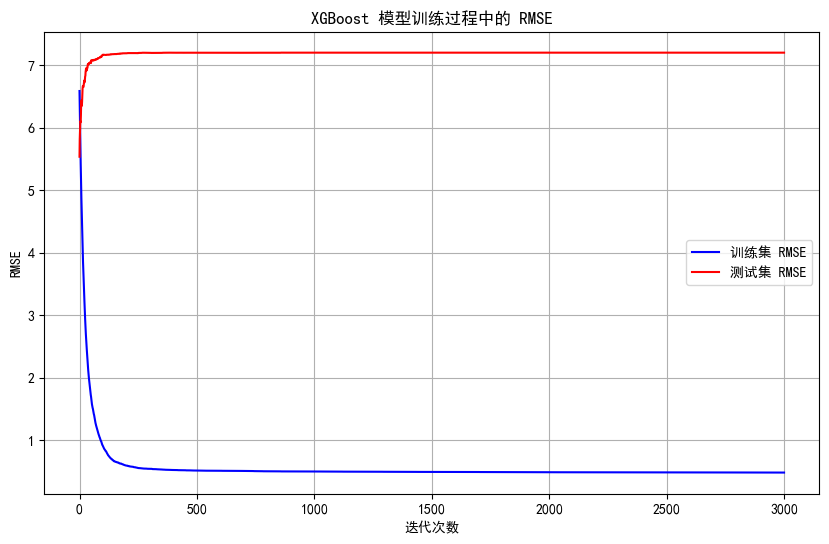

In [16]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:42.09302


[500]	train-rmse:0.27024


[1000]	train-rmse:0.25430


[1500]	train-rmse:0.24655


[2000]	train-rmse:0.24100


[2500]	train-rmse:0.23869


[2999]	train-rmse:0.23625


全部数据 MSE: 0.0677, 全部数据 R²: 1.0


Gap between last actual value and first prediction: -11.260262489318848


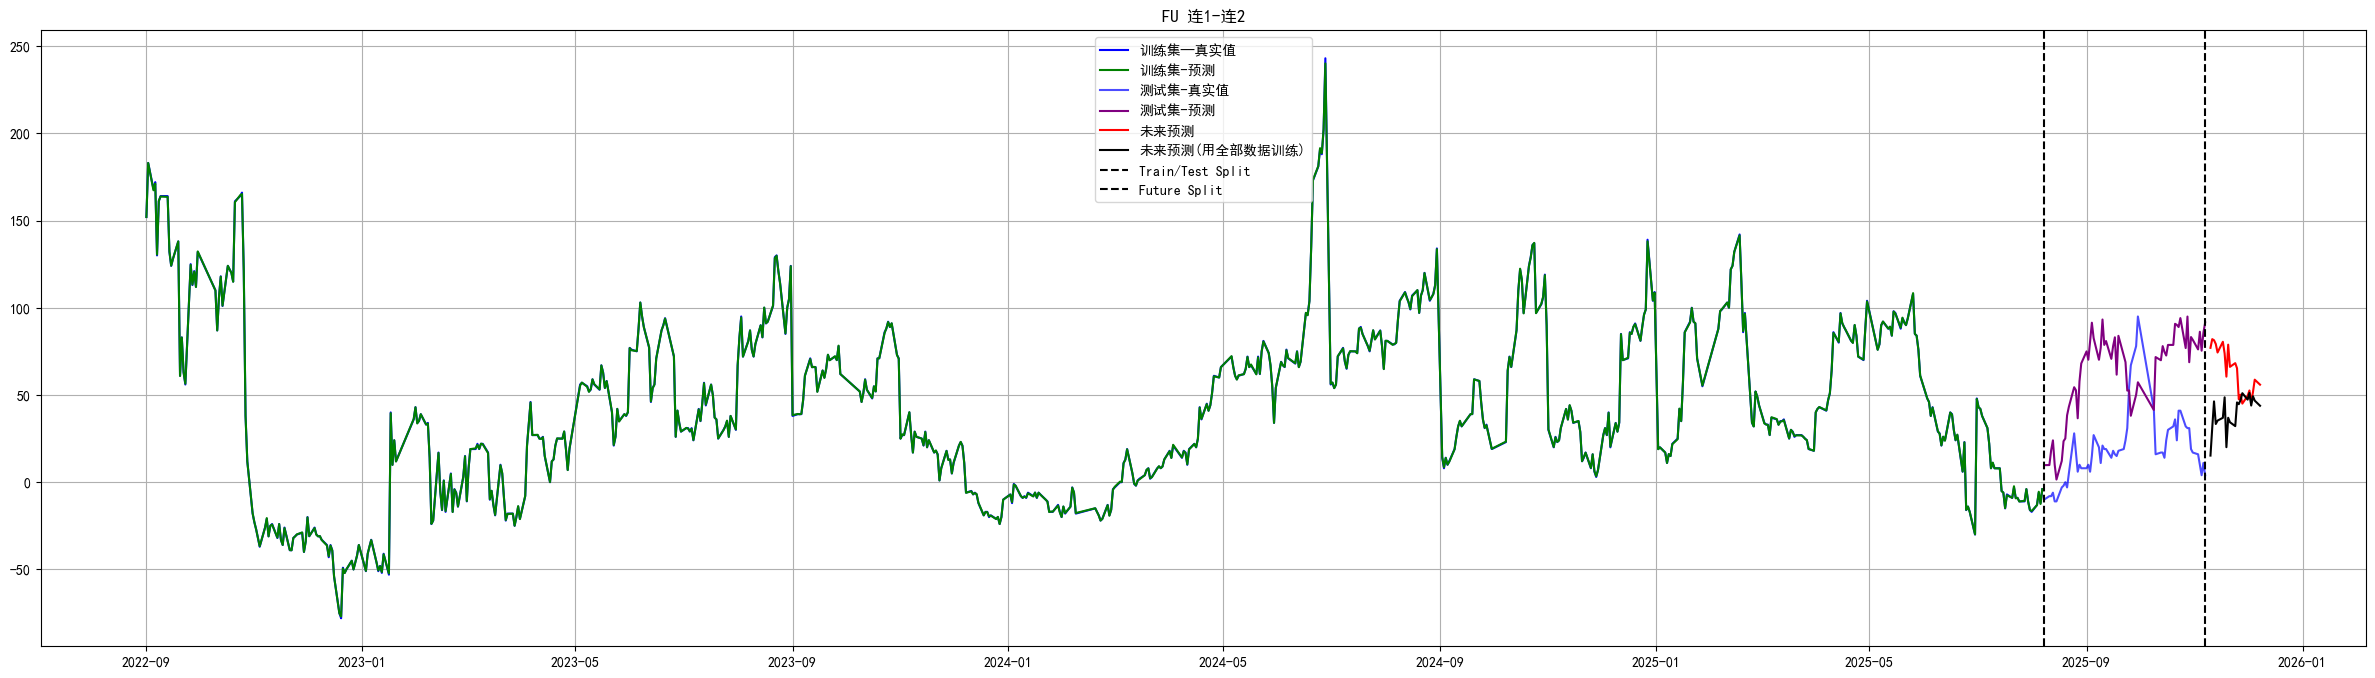

In [18]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('FU 连1-连2')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/FU-连1-连2_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily.head()

,Date,真实值,预测值
709,2025/12/08,NaN,43.820930
708,2025/12/05,NaN,46.759506
707,2025/12/04,NaN,49.275738
706,2025/12/03,NaN,43.958286
705,2025/12/02,NaN,51.186039


In [20]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly = merged_df_monthly.dropna(subset=['真实值', '预测值'], how='all')
merged_df_monthly.to_excel('eta/FU-连1-连2_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly.head()

,Date,真实值,预测值
35,2025/12/31,NaN,47.056873
34,2025/11/30,9.000000,48.702339
33,2025/10/31,27.294118,78.543121
32,2025/09/30,27.500000,71.334923
31,2025/08/31,-1.904762,20.656158


In [21]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "FU-连1-连2"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [22]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "FU-连1-连2"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
